In [1]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math

torch.Size([1, 2500])


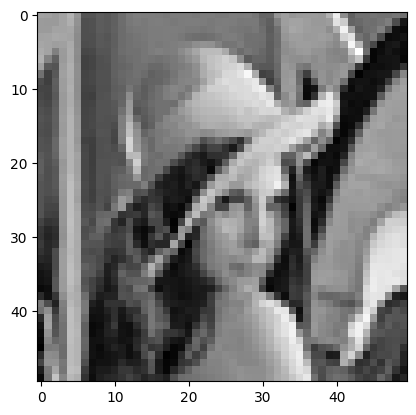

In [2]:
img_num = 4
image = Image.open(f".\images\sample{img_num}.jpg")
#image = Image.open("circle.png")
image = image.resize((50, 50))
image = image.convert("L")

plt.imshow(image, cmap = "gray")
image = torch.tensor(image.getdata())
image = image.view(1, -1)
print(image.shape)

image = 255 - image

torch.Size([5, 2500])


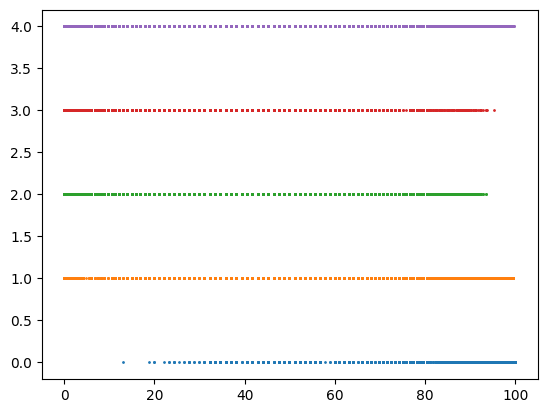

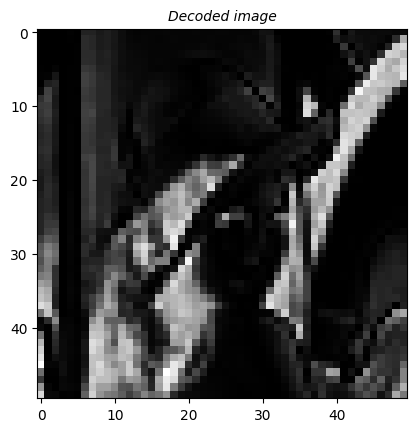

In [3]:
def A():
    ttfs = torch.zeros(image.shape)       
    steps = 10

    ttfs = steps * image // 255

    x = [i for i in range(len(ttfs[0]))]
    y = ttfs[0]

    fig, axs = plt.subplots(2,1)
    fig.set_size_inches(10, 15)

    axs[0].scatter(y, x, c='black', s=1, marker='o', alpha=0.5, label='spikes', zorder=2)
    axs[0].set_xlabel('Time', fontsize=10, fontname='serif', color="black", style='italic')
    axs[0].set_ylabel('Neuron', fontsize=10, fontname='serif', color="black", style='italic')



    # DECODE
    decoded = torch.zeros(image.shape)
    for i in range(len(ttfs[0])):
        decoded[0][i] = y[i] * 255 / steps
        
    decoded = decoded.view(50, 50)

    axs[1].imshow(decoded, cmap = "gray")
    axs[1].set_xlabel('Decoded Image', fontsize=10, fontname='serif', color="black", style='italic')


steps = 100
N = 5                # number of neurons
interval = 255 / N

def gaussian_pdf(mu, sigma):
    return lambda x: 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def gaussian_neuron(mu, sigma):
    G = gaussian_pdf(mu, sigma)
    return lambda x: G(x) * -steps / G(mu) + steps

neurons = [gaussian_neuron(mu = n * interval, sigma = interval) for n in range(N)]

# x = [i for i in range(256)]
# for neuron in neurons:
#     y = [neuron(i) for i in x]
#     plt.plot(x, y)
# plt.axvline(x=128, color='red', linestyle='--')
# plt.show()
    
# plt.title('Gaussian neurons', fontsize=10, style='italic')
# plt.xlabel('Input intensity')
# plt.ylabel('Time to spike')   
# plt.show()



def encode(image, neurons):
    encoded = torch.zeros(len(neurons), len(image[0]))
    for i, neuron in enumerate(neurons):
        for j, pixel in enumerate(image[0]):
            encoded[i][j] = neuron(pixel.item())
    return encoded

encoded = encode(image, neurons)
print(encoded.shape)

for i in range(N):
    plt.scatter(encoded[i, :], [i for j in range(50*50)], s=1)
plt.show()



    
def decode(encoded, neurons):
    decoded = torch.zeros(encoded.shape[1])
    for i in range(len(encoded[0])):
        for j in range(len(encoded)):
            decoded[i] += encoded[j][i]
    decoded = decoded / len(neurons)
    return decoded

decoded = decode(encoded, neurons)
decoded = decoded.view(50, 50)
plt.imshow(decoded, cmap="gray")    
plt.title('Decoded image', fontsize=10, style='italic')
plt.show()



torch.Size([500, 2500])


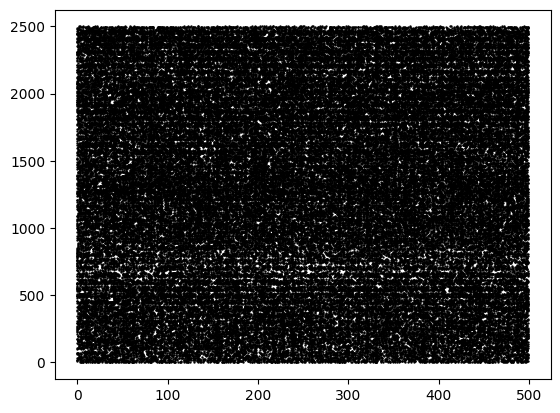

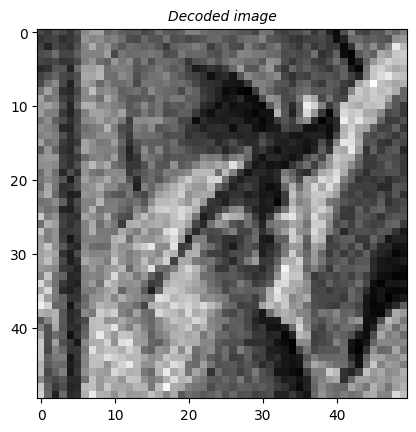

In [48]:
steps = 500              
N = image.shape[1]        
K = 2                     # Maximum number of spikes in poisson distribution's formula

def poisson_pdf(t = 1, k = K):
    return lambda x : (x * t) ** k / math.factorial(k) * np.exp(-x * t)

coded = torch.zeros(steps, N)
for i in range(steps):
    spikes = torch.tensor(
        [[1 if torch.rand(1) < poisson_pdf()(image[0][j] / 255) else 0 for j in range(N)]]
    )
    coded[i] = spikes
print(coded.shape)

plt.scatter(coded.nonzero()[:, 0], coded.nonzero()[:, 1], s = 0.5, c = 'black')
plt.show()


# DECODE
decoded = torch.zeros(image.shape)
for i in range(N):
    decoded[0][i] = torch.sum(coded[:, i]) / steps * 255
    
decoded = decoded.view(50, 50)
plt.imshow(decoded, cmap="gray")
plt.title('Decoded image', fontsize=10, style='italic')
plt.show()